In [139]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from textblob import TextBlob
from datetime import datetime, timedelta, date
from statistics import mean, median
from scipy.stats import mode
import nltk
from sklearn.linear_model import LogisticRegression
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/adamskrocki/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## Stocks Data

In [41]:
stocks = ['AAPL', 'FB', 'NFLX', 'AMZN', 'GOOG']
indices = ['^DJI', '^GSPC']
diffCols = ['Close']

# Adds a column to df for the day by day change of col
def add_day_change(df, cols):
    for col in cols:
        try:
            df[col + '_Diff'] = pd.to_numeric(df[col]).pct_change()
            df[col + "_Diff_Increase"] = df[col + '_Diff'] > 0
        except:
            print(f"Unable to calculate diff for {col}")
            
def add_moving_avg(df, col, n):
    try:
        df[f"Moving_Avg_{col}_{n}"] = df[col].rolling(window=n).mean().shift(1)
    except:
        print(f"Unable to calculate moving avg for {col}")

# Market dfs will store all of our dataframes for stock market data
market_dfs = {}
for symbol in stocks + indices:
    market_dfs[symbol] = pd.read_csv("../Additional Data/" + symbol + '.csv')
    add_day_change(market_dfs[symbol], diffCols)
    market_dfs[symbol].dropna(inplace=True)

In [42]:
market_dfs["^GSPC"].head()

,Date,Open,High,Low,Close,Adj Close,Volume,Close_Diff,Close_Diff_Increase
1,2015-01-05,2054.439941,2054.439941,2017.339966,2020.579956,2020.579956,3799120000,-0.018278,False
2,2015-01-06,2022.150024,2030.250000,1992.439941,2002.609985,2002.609985,4460110000,-0.008893,False
3,2015-01-07,2005.550049,2029.609985,2005.550049,2025.900024,2025.900024,3805480000,0.011630,True
4,2015-01-08,2030.609985,2064.080078,2030.609985,2062.139893,2062.139893,3934010000,0.017888,True
5,2015-01-09,2063.449951,2064.429932,2038.329956,2044.810059,2044.810059,3364140000,-0.008404,False


In [43]:
# Plots a trend for a symbol in the dfs dictionary for the col specified. Standardized divides all data by the mean
def plot_trend(df, col, standardize=False):
    # Figsize
    plt.figure(figsize=(10,6))
    
    # Plot stock price
    trend = df[col] / np.mean(df[col]) if standardize else df[col]
    plt.plot(trend)
    date = df.Date
        
    # Plot config
    locs, _ = plt.xticks()
    plt.xticks(locs[1:-1], date[0:-1:len(date)//(len(locs)-3)])
    plt.title(f'Standardized {col} over Time' if standardize else f'{col} over Time')
    plt.xlabel('Date')
    plt.ylabel(col)
    plt.show()

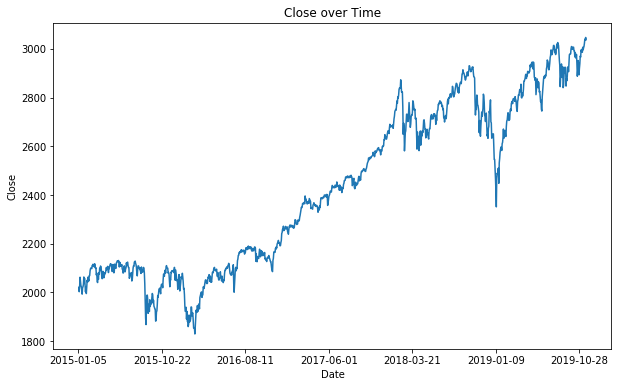

In [44]:
plot_trend(market_dfs["^GSPC"], 'Close')

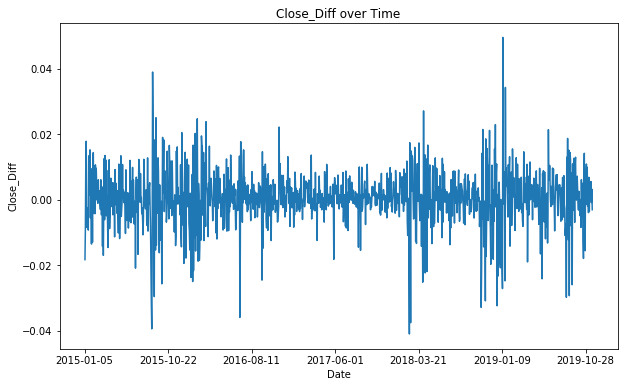

In [45]:
plot_trend(market_dfs["^GSPC"], 'Close_Diff')

## News Data

In [63]:
news = pd.concat([pd.read_csv('../nytimes_2015.csv'), 
                  pd.read_csv('../nytimes_2016.csv'), 
                  pd.read_csv('../nytimes_2017.csv'), 
                  pd.read_csv('../nytimes_2018.csv'), 
                  pd.read_csv('../nytimes_2019.csv')], ignore_index=True)

In [64]:
print(len(news))
news.head()

82533


,web_url,snippet,lead_paragraph,abstract,print_page,source,headline,headline_kicker,headline_content_kicker,headline_print_headline,...,headline_seo,headline_sub,keywords,pub_date,document_type,news_desk,section_name,byline,type_of_material,word_count
0,https://www.nytimes.com/2015/01/08/world/ameri...,"Born through a mix of frustration, satire and ...","MONTERREY, Mexico — Inside a large, open-air b...","Born through a mix of frustration, satire and ...",9.0,The New York Times,A Bus Takes a Local Route to Fighting Mexican ...,Monterrey Journal,NaN,A Bus Takes a Local Route to Fighting Mexican ...,...,NaN,NaN,"[{'name': 'persons', 'value': 'Villegas, Pauli...",2015-01-08T00:45:08+0000,article,Foreign,World,"{'original': 'By Paulina Villegas', 'person': ...",News,1030
1,https://www.nytimes.com/2015/01/11/business/mu...,So-called dark trading — when computers serve ...,"JUDGING solely by the name, stock trading in s...",So-called dark trading — when computers serve ...,29.0,The New York Times,The Rise of Trading in the Dark,Datapoints,NaN,The Rise of Trading in the Dark,...,NaN,NaN,"[{'name': 'subject', 'value': 'Stocks and Bond...",2015-01-09T21:44:42+0000,article,SundayBusiness,Business Day,"{'original': 'By Anna Bernasek', 'person': [{'...",News,366
2,https://www.nytimes.com/2015/01/11/business/fo...,"In the fixed-income market, 2014 was frustrati...",BONDS confounded conventional wisdom in 2014 w...,"In the fixed-income market, 2014 was frustrati...",16.0,The New York Times,"For Bond Investors, That Other Shoe Still Didn...",NaN,NaN,"For Bond Investors, the Other Shoe Still Didn’...",...,NaN,NaN,"[{'name': 'subject', 'value': 'Stocks and Bond...",2015-01-09T21:46:05+0000,article,NODESK,Business Day,"{'original': 'By Carla Fried', 'person': [{'fi...",News,1269
3,https://www.nytimes.com/2015/01/11/business/pe...,A Canadian investor takes a chance on a pace-s...,The typical origin story for a tech company in...,A Canadian investor takes a chance on a pace-s...,1.0,The New York Times,The Uphill Push to Save a Bike-Share Pioneer,NaN,NaN,The Uphill Push to Save a Bike-Share Pioneer,...,NaN,NaN,"[{'name': 'subject', 'value': 'Bicycles and Bi...",2015-01-09T21:03:51+0000,article,SundayBusiness,Business Day,"{'original': 'By Ian Austen', 'person': [{'fir...",News,1923
4,https://www.nytimes.com/2015/01/06/business/in...,"The euro's continued plunge, to a nine-year lo...",FRANKFURT — The value of the euro fell to its ...,"The euro's continued plunge, to a nine-year lo...",5.0,The New York Times,Falling Euro Fans Fears of a Regional Slowdown,NaN,NaN,Sliding Euro Fans Fears of a Slowdown,...,NaN,NaN,"[{'name': 'persons', 'value': 'Ewing, Jack', '...",2015-01-05T21:05:04+0000,article,Business,Business Day,"{'original': 'By Jack Ewing', 'person': [{'fir...",News,1157


### Delete Irrelevant Columns

In [69]:
try: 
    news = news.drop(['web_url', 'byline', 'headline_print_headline', 'document_type'], axis=1)

    # these are missing more than abstract and contain similar info
    news = news.drop(['snippet', 'lead_paragraph'], axis=1)

    # all missing data
    news = news.drop(['headline_content_kicker', 'headline_name', 'headline_seo', 'headline_sub'], axis=1)
    print("Dropped columns")
except: 
    pass 

### Transform Columns to be More Useful

In [70]:
try:
    # make headline include kicker
    news['full_headline'] = news[['headline', 'headline_kicker']].apply(lambda x: x.str.cat(sep=': '), axis=1)

    del news['headline_kicker']
    del news['headline']

    # create whether or not the article was in print
    news['is_print'] = news['print_page'].isna()
    del news['print_page']
    print("Transformed columns")
except:
    pass

Transformed columns


In [95]:
news.head()

,abstract,source,keywords,pub_date,news_desk,section_name,type_of_material,word_count,full_headline,is_print,full_headline_neg,full_headline_neu,full_headline_compound,full_headline_pos
0,"Born through a mix of frustration, satire and ...",The New York Times,"[{'name': 'persons', 'value': 'Villegas, Pauli...",2015-01-08T00:45:08+0000,Foreign,World,News,1030,A Bus Takes a Local Route to Fighting Mexican ...,False,0.217,0.783,-0.3612,0.000
1,So-called dark trading — when computers serve ...,The New York Times,"[{'name': 'subject', 'value': 'Stocks and Bond...",2015-01-09T21:44:42+0000,SundayBusiness,Business Day,News,366,The Rise of Trading in the Dark: Datapoints,False,0.000,1.000,0.0000,0.000
2,"In the fixed-income market, 2014 was frustrati...",The New York Times,"[{'name': 'subject', 'value': 'Stocks and Bond...",2015-01-09T21:46:05+0000,NODESK,Business Day,News,1269,"For Bond Investors, That Other Shoe Still Didn...",False,0.208,0.792,-0.2732,0.000
3,A Canadian investor takes a chance on a pace-s...,The New York Times,"[{'name': 'subject', 'value': 'Bicycles and Bi...",2015-01-09T21:03:51+0000,SundayBusiness,Business Day,News,1923,The Uphill Push to Save a Bike-Share Pioneer,False,0.000,0.652,0.4939,0.348
4,"The euro's continued plunge, to a nine-year lo...",The New York Times,"[{'name': 'persons', 'value': 'Ewing, Jack', '...",2015-01-05T21:05:04+0000,Business,Business Day,News,1157,Falling Euro Fans Fears of a Regional Slowdown,False,0.468,0.532,-0.5267,0.000


### Change to One-Hot Encoding

In [53]:
# from type of material
type_dummies = pd.get_dummies(news['type_of_material'].fillna('Other'), prefix='Type')
news = pd.concat([news, type_dummies], axis=1, join='inner')
news.rename(columns={'Type_briefing': 'Type_Briefing'}, inplace=True)

del news['type_of_material']

In [54]:
# from source
source_dummies = pd.get_dummies(news['source'].fillna('Other'), prefix='Source')
news = pd.concat([news, source_dummies], axis=1, join='inner')

del news['source']

In [55]:
# from news desk
news_desk_dummies = pd.get_dummies(news['news_desk'].fillna('Other'), prefix='Desk')
news = pd.concat([news, news_desk_dummies], axis=1, join='inner')

del news['news_desk']

In [56]:
# from section name
section_name_dummies = pd.get_dummies(news['section_name'], prefix='Section')
news = pd.concat([news, section_name_dummies], axis=1, join='inner')

del news['section_name']

### Change Keywords to Many-Hot Encoding

In [57]:
import ast
from collections import Counter

counter = Counter()

# Get list of all keywords
def get_most_common(x):
    keywords = set()
    for word in ast.literal_eval(x):
        keywords.add(word['value'])
    counter.update(keywords)
    return keywords

news['keywords'] = news['keywords'].apply(get_most_common)

# Pick top 100
most_common = set()
for word, counts in counter.most_common(100):
    most_common.add(word)

# Get the intersection of article's keywords and top 100
def get_keywords(x):
    keywords = x.intersection(most_common)
    return '|'.join(keywords)

# Many-hot
keywords_dummies = news['keywords'].apply(get_keywords).str.get_dummies()
keywords_dummies.rename(columns={x: 'Keyword_' + x for x in keywords_dummies.columns}, inplace=True)
news = pd.concat([news, keywords_dummies], axis=1, join='inner')

del news['keywords']

In [59]:
news.head()

,abstract,pub_date,word_count,full_headline,is_print,Type_An Analysis,Type_An Appraisal,Type_Audio Podcast,Type_Biography,Type_Brief,...,"Keyword_Trump, Donald J",Keyword_Turkey,Keyword_United Nations,Keyword_United States,Keyword_United States Defense and Military Forces,Keyword_United States Economy,Keyword_United States International Relations,Keyword_United States Politics and Government,Keyword_Women and Girls,Keyword_Xi Jinping
0,"Born through a mix of frustration, satire and ...",2015-01-08T00:45:08+0000,1030,A Bus Takes a Local Route to Fighting Mexican ...,False,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,So-called dark trading — when computers serve ...,2015-01-09T21:44:42+0000,366,The Rise of Trading in the Dark: Datapoints,False,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,"In the fixed-income market, 2014 was frustrati...",2015-01-09T21:46:05+0000,1269,"For Bond Investors, That Other Shoe Still Didn...",False,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,A Canadian investor takes a chance on a pace-s...,2015-01-09T21:03:51+0000,1923,The Uphill Push to Save a Bike-Share Pioneer,False,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"The euro's continued plunge, to a nine-year lo...",2015-01-05T21:05:04+0000,1157,Falling Euro Fans Fears of a Regional Slowdown,False,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Time & Date

In [119]:
# def time_of_day(hour):
#     if hour >= 6 and hour < 12:
#         return 0
#     if hour >= 12 and hour < 17:
#         return 1
#     if hour >= 17 and hour < 22:
#         return 2
#     return 3

# news['time'] = news['pub_date'].apply(lambda x: time_of_day(datetime.fromisoformat(x[:-5]).time().hour))
# news['date'] = news['pub_date'].apply(lambda x: str(date.fromisoformat(x.strip()[:10]) + timedelta(days=1)))

if 'pub_date' in news.columns:
    news['date'] = news['pub_date'].apply(lambda x: str(x[:10]))
    del news['pub_date']

### Sentiment Analysis

In [96]:
# Adds sentiment by TextBlob (polarity and subjectivity) to a df based on its col column
def add_textblob_sentiment(df, col):
    def polarity_and_subjectivity(x):
        sentiment = TextBlob(str(x)).sentiment
        return sentiment.polarity, sentiment.subjectivity
    df[f'{col}_polarity'], df[f'{col}_subjectivity'] = zip(*df[col].map(polarity_and_subjectivity))
    
def add_nltk_sentiment(df, col):
    sid = SentimentIntensityAnalyzer()
    def polarity_and_subjectivity(x):
        sentiment = sid.polarity_scores(str(x))
        return list(sentiment.values())
    df[f'{col}_neg'], df[f'{col}_neu'], df[f'{col}_pos'], df[f'{col}_compound'] = zip(*df[col].map(polarity_and_subjectivity))

In [120]:
if 'abstract' in news.columns and 'full_headline' in news.columns: 
    add_textblob_sentiment(news, 'abstract')
    add_textblob_sentiment(news, 'full_headline')
    add_nltk_sentiment(news, 'abstract')
    add_nltk_sentiment(news, 'full_headline')
    news = news.drop(['abstract', 'full_headline'], axis=1)

In [121]:
len(news.columns)

20

In [127]:
n = 5
sp500_history = sp500[n:]
sp500_history.reset_index(drop=True, inplace=True)
for x in range(1, n+1):
    sp500_history[f'T-{x} Close_Diff'] = sp500['Close_Diff'][n-x:-x].values
    sp500_history[f'T-{x} Close_Diff_Increase'] = sp500['Close_Diff_Increase'][n-x:-x].values

/Users/Abby/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/Abby/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [130]:
sp500_history.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'Close_Diff', 'Close_Diff_Increase', 'T-1 Close_Diff',
       'T-1 Close_Diff_Increase', 'T-2 Close_Diff', 'T-2 Close_Diff_Increase',
       'T-3 Close_Diff', 'T-3 Close_Diff_Increase', 'T-4 Close_Diff',
       'T-4 Close_Diff_Increase', 'T-5 Close_Diff', 'T-5 Close_Diff_Increase'],
      dtype='object')

In [129]:
df = news.merge(sp500_history, left_on='date', right_on='Date')
df = df.drop(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], axis=1)

In [127]:
news_average = news.groupby('date').mean().reset_index()

In [137]:
full_dfs = {}
for symbol in stocks + indices:  
    full_dfs[symbol] = news_average.merge(market_dfs[symbol], left_on='date', right_on='Date')

## Models: Average All Articles

In [177]:
news_average = news.groupby('date').mean().reset_index()
df_average = news_average.merge(sp500_history, left_on='date', right_on='Date')
df_average = df_average.drop(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], axis=1)

train = df[df['date'].apply(lambda x: date.fromisoformat(x) < date.fromisoformat('2019-01-01'))]
test = df[df['date'].apply(lambda x: date.fromisoformat(x) >= date.fromisoformat('2019-01-01'))]

X_train = train.drop(['date', 'Close_Diff', 'Close_Diff_Increase'], axis=1)
Y_train = train[['Close_Diff', 'Close_Diff_Increase']]

X_test = test.drop(['date', 'Close_Diff', 'Close_Diff_Increase'], axis=1)
Y_test = test[['Close_Diff', 'Close_Diff_Increase']]

In [179]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

regressor = LinearRegression()
regressor.fit(X_train, Y_train['Close_Diff'])

mean_squared_error(Y_test['Close_Diff'], regressor.predict(X_test))

457.95571483555767

In [180]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression(max_iter=10000)
classifier.fit(X_train, Y_train['Close_Diff_Increase'])

classifier.score(X_test, Y_test['Close_Diff_Increase'])

0.539864063005718

## Models: Basic Classifiers and Regressors

In [132]:
def average(results):
    return sum(results) / len(results)

def weighted_average(results, weights):
    return results.dot(abs(weights)) / sum(abs(weights))

def tt_split(X, y, test_size=0.2):
    assert len(X) == len(y)
    
    n_test = int(len(X)*test_size)
    
    X_train = X.loc[:len(X)-n_test]
    y_train = y.loc[:len(X)-n_test]
    X_test = X.loc[len(X)-n_test:]
    y_test = y.loc[len(X)-n_test:]
    return X_train, X_test, y_train, y_test

In [147]:
def makeDfForTimeReg(df, cols, n_prev_days=5):
    new_df = pd.DataFrame(df[cols])
    for col in cols:
        for i in range(n_prev_days):
            new_df[col + "_" + str(i+1)] = new_df[col].shift(i+1)
    return new_df.dropna(axis=0)

In [149]:
n_prev_days = 1
relevant_cols = ['Close_Diff', 'full_headline_neg', 'full_headline_neu', 'full_headline_pos', 'full_headline_compound', 'abstract_neg', 'abstract_neu', 'abstract_compound', 'abstract_pos']

for symbol in stocks + indices:
    print(symbol)
    
    df = makeDfForTimeReg(full_dfs[symbol], relevant_cols, n_prev_days=n_prev_days)
    df["Close_Diff_Increase"] = full_dfs[symbol]["Close_Diff_Increase"]
    
    X_cols = []
    for col in relevant_cols:
        X_cols += [col + "_" + str(i+1) for i in range(n_prev_days)]
    
    y_cols = ["Close_Diff_Increase", "Close_Diff"]
    X_train, X_test, y_train, y_test = tt_split(df[X_cols], df[y_cols], test_size=0.2)

    classifier = LogisticRegression()
    classifier.fit(X_train, y_train["Close_Diff_Increase"])
    
    preds = classifier.predict(X_test)
    
    acc = average(preds == y_test['Close_Diff_Increase'])
    weighted_acc = weighted_average(preds == y_test['Close_Diff_Increase'], y_test['Close_Diff'])
    print(f'Last {n_prev_days} days acc: {acc}')
    print(f'Last {n_prev_days} days weighted acc: {weighted_acc}')

AAPL
Last 1 days acc: 0.5409836065573771
Last 1 days weighted acc: 0.5364242101972471
FB
Last 1 days acc: 0.5245901639344263
Last 1 days weighted acc: 0.5473697080463348
NFLX
Last 1 days acc: 0.48770491803278687
Last 1 days weighted acc: 0.452539235526017
AMZN
Last 1 days acc: 0.5327868852459017
Last 1 days weighted acc: 0.5123732178011697
GOOG
Last 1 days acc: 0.5081967213114754
Last 1 days weighted acc: 0.45644106559015585
^DJI
Last 1 days acc: 0.5409836065573771
Last 1 days weighted acc: 0.515414330973502
^GSPC
Last 1 days acc: 0.5573770491803278
Last 1 days weighted acc: 0.529635151927323


In [155]:
train = df[df['date'].apply(lambda x: date.fromisoformat(x) < date.fromisoformat('2019-01-01'))]
test = df[df['date'].apply(lambda x: date.fromisoformat(x) >= date.fromisoformat('2019-01-01'))]

X_train = train.drop(['date', 'Close_Diff', 'Close_Diff_Increase'], axis=1)
Y_train = train[['Close_Diff', 'Close_Diff_Increase']]

X_test = test.drop(['Close_Diff', 'Close_Diff_Increase'], axis=1)
Y_test = test[['date', 'Close_Diff', 'Close_Diff_Increase']]

In [135]:
from sklearn.linear_model import LinearRegression

regressor = LinearRegression()
regressor.fit(X_train, Y_train['Close_Diff'])

predictions = X_test.groupby('date').apply(regressor.predict).apply(lambda x: median(x) > 0)
results = predictions.values == Y_test.groupby('date').first()['Close_Diff_Increase'].values
print(f'Average: {average(results)}')
print('Weighted Average: {}'.format(weighted_average(results, abs(Y_test.groupby('date').first()['Close_Diff']))))

Average: 0.5260663507109005
Weighted Average: 0.5450282753739122


In [137]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

regressor = LinearRegression()
regressor.fit(X_train, Y_train['Close_Diff'])

predictions = X_test.groupby('date').apply(regressor.predict).apply(median)
mean_squared_error(Y_test.groupby('date').first()['Close_Diff'], predictions)

564.1751516756917

In [165]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression(max_iter=10000)
classifier.fit(X_train, Y_train['Close_Diff_Increase'])

predictions = X_test.groupby('date').apply(classifier.predict).apply(lambda x: mode(x)[0])
results = predictions.values == Y_test.groupby('date').first()['Close_Diff_Increase'].values
print(f'Average: {average(results)}')
print('Weighted Average: {}'.format(weighted_average(results, abs(Y_test.groupby('date').first()['Close_Diff']))))

Average: 0.5023696682464455
Weighted Average: 0.4711751124813932


## Models: Stacking

In [138]:
train = df[df['date'].apply(lambda x: date.fromisoformat(x) < date.fromisoformat('2019-01-01'))]
test = df[df['date'].apply(lambda x: date.fromisoformat(x) >= date.fromisoformat('2019-01-01'))]

X_train = train.drop(['date', 'Close_Diff', 'Close_Diff_Increase'], axis=1)
Y_train = train[['Close_Diff', 'Close_Diff_Increase']]

X_test = test.drop(['Close_Diff', 'Close_Diff_Increase'], axis=1)
Y_test = test[['date', 'Close_Diff', 'Close_Diff_Increase']]

In [143]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error

# fit classifier model to predict increase/ decrease
classifier1 = LogisticRegression(max_iter=10000)
classifier1.fit(X_train, Y_train['Close_Diff_Increase'])

# fit classifier model to predict which are best
classifier2 = LogisticRegression(max_iter=10000)
c1_accuracy = classifier1.predict(X_train) == Y_train['Close_Diff_Increase']
classifier2.fit(X_train, c1_accuracy)

# fit regression model to predict difference
regressor = LinearRegression()
x_with_importance = X_train
x_with_importance['importance'] = classifier2.predict(X_train)
regressor.fit(x_with_importance[x_with_importance.columns], Y_train['Close_Diff'])

X_test['importance'] = classifier2.predict(X_test.drop(['date'], axis=1))
predictions = X_test.groupby('date').apply(regressor.predict).apply(lambda x: median(x))
mean_squared_error(Y_test.groupby('date').first()['Close_Diff'], predictions)

564.5325580121058

In [144]:
predictions = X_test.groupby('date').apply(regressor.predict).apply(lambda x: median(x) > 0)
results = predictions.values == Y_test.groupby('date').first()['Close_Diff_Increase'].values
print(f'Average: {average(results)}')
print('Weighted Average: {}'.format(weighted_average(results, abs(Y_test.groupby('date').first()['Close_Diff']))))

Average: 0.5308056872037915
Weighted Average: 0.537163855865799


In [146]:
train = df[df['date'].apply(lambda x: date.fromisoformat(x) < date.fromisoformat('2019-01-01'))]
test = df[df['date'].apply(lambda x: date.fromisoformat(x) >= date.fromisoformat('2019-01-01'))]

X_train = train.drop(['date', 'Close_Diff', 'Close_Diff_Increase'], axis=1)
Y_train = train[['Close_Diff', 'Close_Diff_Increase']]

X_test = test.drop(['Close_Diff', 'Close_Diff_Increase'], axis=1)
Y_test = test[['date', 'Close_Diff', 'Close_Diff_Increase']]

In [147]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error

# fit classifier model to predict increase/ decrease
classifier1 = LogisticRegression(max_iter=10000)
classifier1.fit(X_train, Y_train['Close_Diff_Increase'])

# fit classifier model to predict which are best
classifier2 = LogisticRegression(max_iter=10000)
c1_accuracy = classifier1.predict(X_train) == Y_train['Close_Diff_Increase']
classifier2.fit(X_train, c1_accuracy)

# fit regression model to predict difference
regressor = LinearRegression()
x_train_with_importance = X_train[classifier2.predict(X_train)]
y_train_with_importance = Y_train[classifier2.predict(X_train)]
regressor.fit(x_train_with_importance, y_train_with_importance['Close_Diff'])

x_test_with_importance = X_test[classifier2.predict(X_test.drop(['date'], axis=1))]
y_test_with_importance = Y_test[classifier2.predict(X_test.drop(['date'], axis=1))]
predictions = x_test_with_importance.groupby('date').apply(regressor.predict).apply(lambda x: median(x))
mean_squared_error(y_test_with_importance.groupby('date').first()['Close_Diff'], predictions)

564.0825744110602

In [148]:
predictions = x_test_with_importance.groupby('date').apply(regressor.predict).apply(lambda x: median(x) > 0)
results = predictions.values == Y_test.groupby('date').first()['Close_Diff_Increase'].values
print(f'Average: {average(results)}')
print('Weighted Average: {}'.format(weighted_average(results, abs(Y_test.groupby('date').first()['Close_Diff']))))

Average: 0.5260663507109005
Weighted Average: 0.5147811382072358


## Models: Random Forest Classifier (TERRIBLE)

In [131]:
X = df.drop(['date', 'Close_Diff', 'Close_Diff_Increase'], axis=1)
Y = df['Close_Diff_Increase']

In [132]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

classifier = RandomForestClassifier(max_depth=2)
classifier.fit(X_train, Y_train)
classifier.score(X_test, Y_test)

0.536517797179315

In [133]:
sum(classifier.predict(X_test)) / len(X_test)

1.0

In [49]:
# train = df[df['date'].apply(lambda x: date.fromisoformat(x) < date.fromisoformat('2018-01-01'))]
# validate = df[df['date'].apply(lambda x: date.fromisoformat(x) >= date.fromisoformat('2018-01-01') and date.fromisoformat(x) < date.fromisoformat('2019-01-01'))]
# test = df[df['date'].apply(lambda x: date.fromisoformat(x) >= date.fromisoformat('2019-01-01'))]
train = df[df['date'].apply(lambda x: date.fromisoformat(x) < date.fromisoformat('2019-01-01'))]
test = df[df['date'].apply(lambda x: date.fromisoformat(x) >= date.fromisoformat('2019-01-01'))]

X_train = train.drop(['date', 'Close_Diff_Increase'], axis=1)
# X_validate = validate.drop(['date', 'Close_Diff_Increase'], axis=1)
X_test = test.drop(['Close_Diff_Increase'], axis=1)
Y_train = train['Close_Diff_Increase']
# Y_validate = validate['Close_Diff_Increase']
Y_test = test[['date', 'Close_Diff_Increase']]

In [50]:
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier(max_depth=2)
classifier.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=2, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [51]:
predictions = X_test.groupby('date').apply(classifier.predict).apply(lambda x: mode(x)[0])
print(sum(predictions.values == Y_test.groupby('date').first()['Close_Diff_Increase'].values) / len(predictions))

0.5781990521327014


In [52]:
sum(predictions) / len(predictions)

1.0

In [33]:
# # messing with cutoff

# def do_something(values):
#     values.sort()
#     n = len(values) // 5
#     return (sum(values[:n]) + sum(values[-n:])) / (2*n)

# trues = []
# falses = []
# for _, y in test.groupby('date'):
#     x = do_something(classifier.predict_proba(X_test.loc[y.index])[:,0])
#     if Y_test[y.index].iloc[0]:
#         trues.append(x)
#     else:
#         falses.append(x)